In [191]:
## LSTM - A-95 - single step model
'''Точечное прогнозирование. В данном случае модель обучается прогнозированию одного значения в будущем 
на основе имеющейся истории по набору переменных.'''

'Точечное прогнозирование. В данном случае модель обучается прогнозированию одного значения в будущем \nна основе имеющейся истории по набору переменных.'

In [192]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [193]:
# Importing the dataset
df = pd.read_excel('cena1.xlsx', encoding='ISO-8859-1')

In [194]:
df

,Date,Price,Kurs_dollar,Kurs_euro,Oil_price,Used
0,2017-01-03,23.82,27.190858,28.422604,55.64,57.611681
1,2017-01-04,23.85,27.190858,28.422604,56.25,57.571419
2,2017-01-05,23.85,26.692366,27.858822,56.77,57.532696
3,2017-01-06,23.87,26.286719,27.603684,56.82,57.496014
4,2017-01-10,23.87,27.020929,28.612462,53.64,57.379405
...,...,...,...,...,...,...
877,2020-07-27,22.87,27.755900,32.224600,43.95,77.059356
878,2020-07-28,22.87,27.757100,32.604900,43.65,76.648569
879,2020-07-29,22.87,27.685100,32.453900,44.10,76.239853
880,2020-07-30,22.89,27.686700,32.469600,43.61,75.834026


In [195]:
# Features 
features_considered = ['Price','Kurs_dollar','Kurs_euro','Oil_price','Used']
features = df[features_considered]
features.index = df['Date']
features.head()

,Price,Kurs_dollar,Kurs_euro,Oil_price,Used
Date,,,,,
2017-01-03,23.82,27.190858,28.422604,55.64,57.611681
2017-01-04,23.85,27.190858,28.422604,56.25,57.571419
2017-01-05,23.85,26.692366,27.858822,56.77,57.532696
2017-01-06,23.87,26.286719,27.603684,56.82,57.496014
2017-01-10,23.87,27.020929,28.612462,53.64,57.379405


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001AABC47A9D0>,
      dtype=object)

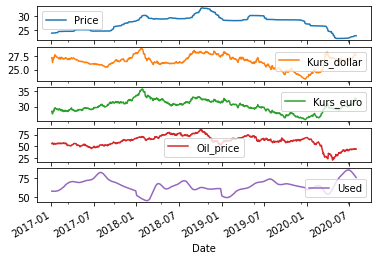

In [196]:
# Plotting data
features.plot(subplots=True)

In [197]:
'''Точечное прогнозирование. В данном случае модель обучается прогнозированию одного значения в будущем 
на основе имеющейся истории.
Приведенная функция выполняет задачу организации временных интервалов, отбирая последние наблюдения 
на основе заданного размера шага.'''
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [198]:
'''Первые 700 строк данных будут использоваться для обучения модели, оставшиеся – для её валидации (проверки). 
В этом случае объём обучающих данных составляет примерно 322 дня.'''
# Splitting dataset
TRAIN_SPLIT = 700
dataset = df.iloc[:, 1:6].pct_change()
dataset_array = dataset.values
dataset_array[1:]

array([[ 1.25944584e-03,  0.00000000e+00,  0.00000000e+00,
         1.09633357e-02, -6.98854722e-04],
       [ 0.00000000e+00, -1.83330736e-02, -1.98356913e-02,
         9.24444444e-03, -6.72597510e-04],
       [ 8.38574423e-04, -1.51971167e-02, -9.15824797e-03,
         8.80746873e-04, -6.37596076e-04],
       ...,
       [ 0.00000000e+00, -2.59393092e-03, -4.63120574e-03,
         1.03092784e-02, -5.33233923e-03],
       [ 8.74508089e-04,  5.77928200e-05,  4.83763122e-04,
        -1.11111111e-02, -5.32302681e-03],
       [ 0.00000000e+00,  1.66144755e-04,  2.38376820e-03,
         2.29305205e-03, -5.30315756e-03]])

In [205]:
''''''
# Creating lagged dataset
past_history = 49
future_target = 7
STEP = 7

x_train_single, y_train_single = multivariate_data(dataset_array[1:], dataset_array[1:, 1:2], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset_array[1:], dataset_array[1:, 1:2],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [207]:
'''Проверим временной интервал'''
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (7, 5)


In [208]:
# Importing the Tensorflow libraries and packages
import tensorflow as tf
#from tf.data import Dataset

# Importing the Keras libraries and packages
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

In [209]:
'''C помощью tf.data выполним перемешивание (shuffle), пакетирование (batch) и кэширование (cache) набора данных.'''
# Data preprocessing
BATCH_SIZE = 35
BUFFER_SIZE = 50

train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat() 

In [210]:
# LSTM creating
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(5,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

In [211]:
'''Проверим выборку'''
single_step_model.predict(val_data_single.take(1)).shape

(35, 1)

In [212]:
'''Обучим модель и  выведем кривые потерь на этапах обучения и проверки'''
# Fitting
EVALUATION_INTERVAL = 50
EPOCHS = 10
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Epoch 1/10
50/50 [==============================] - 1s 19ms/step - loss: 0.0034 - val_loss: 0.0043
Epoch 2/10
50/50 [==============================] - 0s 6ms/step - loss: 0.0033 - val_loss: 0.0043
Epoch 3/10
50/50 [==============================] - 0s 6ms/step - loss: 0.0033 - val_loss: 0.0044
Epoch 4/10
50/50 [==============================] - 0s 6ms/step - loss: 0.0031 - val_loss: 0.0041
Epoch 5/10
50/50 [==============================] - 0s 6ms/step - loss: 0.0032 - val_loss: 0.0042
Epoch 6/10
50/50 [==============================] - 0s 6ms/step - loss: 0.0031 - val_loss: 0.0042
Epoch 7/10
50/50 [==============================] - 0s 6ms/step - loss: 0.0031 - val_loss: 0.0045
Epoch 8/10
50/50 [==============================] - 0s 6ms/step - loss: 0.0031 - val_loss: 0.0048
Epoch 9/10
50/50 [==============================] - 0s 6ms/step - loss: 0.0031 - val_loss: 0.0041
Epoch 10/10
50/50 [==============================] - 0s 6ms/step - loss: 0.0031 - val_loss: 0.0042


In [213]:
# Plotting history function
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

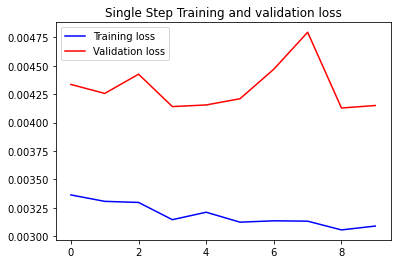

In [214]:
# Plotting history
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

In [215]:
def create_time_steps(length):
  return list(range(-length, 0))

In [216]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

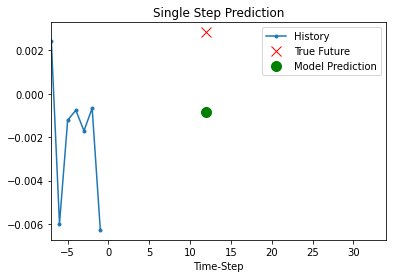

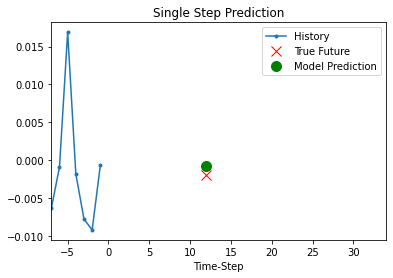

In [218]:
'''Выполнение точечного прогноза.
Когда модель обучена, выполним несколько пробных прогнозов. 
На вход модели подаётся история наблюдений 2-х признаков за последние пять дней, 
отобранных каждый час (временной интервал = 120). 
Так как цель заключается в прогнозе только температуры, синим цветом на графике отображены прошлые значения температуры 
(история). Прогноз выполнен на полдня в будущее (отсюда разрыв между историей и спрогнозированным значением).'''
# LSTM Prediction plotting
for i in range(0,47,24):
    plot = show_plot([x_val_single[i][:, 1], y_val_single[i], single_step_model.predict(val_data_single.take(3))[i]], 12,
           'Single Step Prediction')
    plot.show()